# TmB physiological data analysis

This script:

1. loads in all the participant data
2. Cleans up the data accordingly i.e. renames columns etc. 
3. Plots the raw data
4. Export data into the correct format for SPSS

## 1. Load data

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
import numpy as np
from scipy.signal import savgol_filter
import os

import pingouin as pg
from statannot import add_stat_annotation

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
path = "C:/Users/VR-Lab/Documents/Projects/LH_Project/Data/Tahani's study data/"
# path = "C:/Users/Monter/Projects/LH_Project/Data/Tahani's study data/"

### Functions

In [3]:
def RMSSD_Compute(data_df, plotting=False):
    
    # Example trial from an example participant for testing and understanding HRV
    # testmask = (df['Participant_ID'] == 'yu191230') & (df['phase'] == 'Phase_1')

    # Get the values into a new variable for ease of use 
    vals = data_df['heart_rate'].values

#     # Compute the sampling rate using time and number of samples 
#     trialDuration = data_df['time'].values[-1] - data_df['time'].values[0] # in seconds 
#     numbSamples = len(data_df['time'].values)
#     sampleRate = np.round(numbSamples/trialDuration)

    # Find the peaks using an arbitrary height value, i.e. ignore all peaks below that value e.g. 600
    pks,_ = find_peaks(vals, height=750, prominence=150, distance=25)

    heart_rate = len(pks) # number of peaks in a minute 
    RR = np.diff(pks)
    rmssd = np.sqrt(np.mean(np.square(np.diff(RR)))) # Same formula as Lily's document 
    # standardDeviationOfRR = np.std(RR)
    
#     print("Val: " + str(rmssd) + " Type: " + str(type(rmssd)))
    
    if plotting:
        # Display plots of the heart rate and detected peaks 
        plt.plot(vals, color='r', linewidth=2)
        plt.plot(pks, vals[pks],'xk',markersize=8)
        plt.xlim([0,500])
        plt.xlabel('Time / s', fontsize=14)
        plt.ylabel('ECG', fontsize=14)
        plt.savefig('HeartRate_Example.png', dpi=600, bbox_inches='tight')
    
    return rmssd

## 1. Load all participant data collected so far

In [4]:
files = os.listdir(path)

tmpDF = None
df = None

for file in files:
    if 'json' in file:
        tmpDF = pd.read_json(path+file)
        
        file_words = file.split('_')
        tmpDF['Participant_ID'] = file_words[1]
        
        if df is None:
            df = tmpDF
        else:
            df = pd.concat((df, tmpDF))        
df.head(3)

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,467,96,0.485157,startNow,100876,1,tahani
1,450,189,0.494686,startNow,100876,1,tahani
2,446,283,0.505369,startNow,100876,1,tahani


In [5]:
len(pd.unique(df['Participant_ID']))

79

## 2. Clean up the data 

In [6]:
df

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
0,467,96,0.485157,startNow,100876,1,tahani
1,450,189,0.494686,startNow,100876,1,tahani
2,446,283,0.505369,startNow,100876,1,tahani
3,462,377,0.516250,startNow,100876,1,tahani
4,463,470,0.527218,startNow,100876,1,tahani
...,...,...,...,...,...,...,...
30395,501,505,328.708707,stress_end,99823,1,tahani
30396,486,505,328.719675,stress_end,99823,1,tahani
30397,489,504,328.729647,stress_end,99823,1,tahani
30398,474,505,328.740616,stress_end,99823,1,tahani


In [13]:
pd.unique(df['phase'])

array(['startNow', 'start_experiment', 'buggy_journey',
       'fix_buggy_instructions', 'storm_instructions', 'end_instructions',
       'stress_1o3', 'stress_2o3', 'stress_3o3', 'stress_end',
       'experiment_end'], dtype=object)

In [17]:
mask = (df['Participant_ID'] == "99823") & (df['phase'] == "stress_3o3")

len(df[mask]['time'])

5615

### List phases present in the experiment

In [37]:
pd.unique(df['phase'])

array(['startNow', 'start_experiment', 'buggy_journey',
       'fix_buggy_instructions', 'storm_instructions', 'end_instructions',
       'stress_1o3', 'stress_2o3', 'stress_3o3', 'stress_end',
       'experiment_end'], dtype=object)

In [38]:
# participants_to_update = df.loc[df['phase'] == 'calm_1o3', 'Participant_ID'].unique()

# # Update "Condition" column to 0 for rows belonging to identified participants
# for participant in participants_to_update:
#     df.loc[df['Participant_ID'] == participant, 'Condition'] = 0
    
# df.head(3)

### For ease of analysis, rename the stress and calm conditions to numbers

e.g.
stress_1o1 and calm_1o1 will become p1 and 
stress_1o2 and calm_1o2 will become p2 etc. 

We can afford to do this now because we separated out the conditions to 0 for calm and 1 for stress so we do not need the phases in order to tell which condition the participant experienced in the experiment

This will make plotting the figures simpler, i.e. instead of seeing 6 phases (3 for the calm plut 3 for the stress conditions) we now only see 3 phases in total and we use the condition parameter to separate out which is stress and which is calm

In [39]:
# # Rename the conditions from numbers to words i.e. condition 0 = calm and condition 1 = stress 
# df['Condition'] = df['Condition'].replace({0: 'Calm', 1: 'Stress'})
# df['Condition'] = df['Condition'].replace({3: 'Stress'})

# # Rename the 3 phases in the calm and stress conditions to phases 1 to 3
# df['phase'] = df['phase'].replace({'calm_1o3': 'Phase_1', 'stress_1o3': 'Phase_1'})
# df['phase'] = df['phase'].replace({'calm_2o3': 'Phase_2', 'stress_2o3': 'Phase_2'})
# df['phase'] = df['phase'].replace({'calm_3o3': 'Phase_3', 'stress_3o3': 'Phase_3'})

# # Rename calm or stress end phases to phase end 
# df['phase'] = df['phase'].replace({'calm_end': 'Washout', 'stress_end': 'Washout'})

# # Rename to baseline for the initial baseline part of the experiment
# df['phase'] = df['phase'].replace({'end_instructions': 'Baseline'})


### For the analysis, only use those phases that are relevant for your particular intervention and exclude the rest, which is what we are doing here

In [40]:
# excludePhases = (df['phase']!='startNow') & (df['phase']!='start_experiment') & (df['phase']!='buggy_journey') & (df['phase']!='fix_buggy_instructions') & (df['phase']!='storm_instructions') & (df['phase']!='experiment_end') & (df['Participant_ID']!= 3)
excludePhases = (df['phase']!='startNow') & (df['phase']!='start_experiment') & (df['phase']!='buggy_journey') & (df['phase']!='fix_buggy_instructions') & (df['phase']!='storm_instructions') & (df['phase']!='experiment_end')

## 3. Raw data plots

### Here use the above selected phases on your plots and for the analysis to filter the data 

#### For GSR we may need to normalise according to each participant's baseline values

In [41]:
# We took the inverse of the resistance to convert the values to conductance 
# df['gsr_response'] = 1/df['gsr_response']

### Heart Rate Raw plots

In [42]:
df2 = df[excludePhases]

In [43]:
pd.unique(df2['Participant_ID'])

array(['100876', '100', '101092', '101194', '101200', '101248', '101329',
       '101347', '101401', '101443', '101485', '101488', '101521',
       '101584', '101602', '101632', '101688', '101698', '101761',
       '101842', '101857', '101866', '101881', '101893', '102484',
       '102508', '102511', '102640', '102703', '106348', '106366',
       '106918', '10', '110', '112096', '112171', '11', '120', '12', '13',
       '140', '14', '150', '160', '16', '200', '27', '2', '300', '30',
       '350', '3', '400', '40', '450', '500', '50', '5', '60', '6', '70',
       '7', '80', '84598', '85024', '8', '90', '97084', '97102', '97138',
       '97273', '97318', '97354', '97399', '97420', '97471', '97888',
       '99748', '99823'], dtype=object)

In [54]:
pd.unique(df2['phase'])

array(['end_instructions', 'stress_1o3', 'stress_2o3', 'stress_3o3',
       'stress_end'], dtype=object)

In [44]:
mask = (df2['Condition'] == 1)
pd.unique(df2[mask]['Participant_ID'])

len(pd.unique(df2[mask]['Participant_ID']))

79

In [45]:
pd.unique(df2['phase'])

array(['end_instructions', 'stress_1o3', 'stress_2o3', 'stress_3o3',
       'stress_end'], dtype=object)

### Example participant and example trial plot (extract from a few milliseconds)

<Axes: xlabel='time', ylabel='heart_rate'>

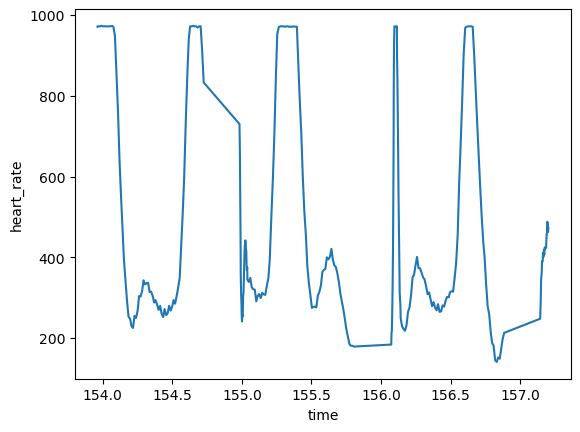

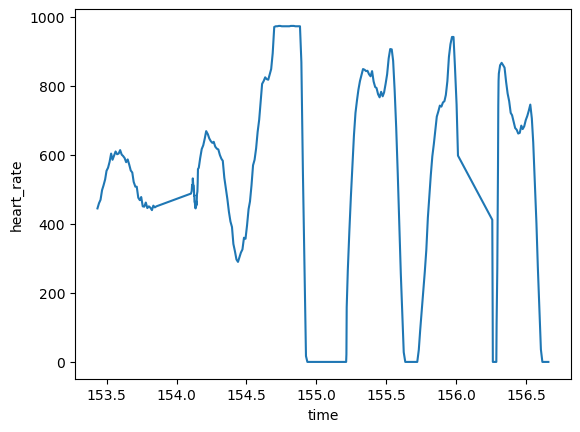

In [50]:
plt.figure()
mask = (df2["Participant_ID"] == '101602') & (df2['Condition'] == 1) & (df2['phase'] == 'stress_2o3')  
sns.lineplot(x = 'time', y = 'heart_rate', data=df2[mask][100:400])
# plt.savefig('Stress HR example 1.png', dpi=350, bbox_inch=True)

plt.figure()
mask = (df2["Participant_ID"] == '85024') & (df2['Condition'] == 1) & (df2['phase'] == 'stress_2o3')  
sns.lineplot(x = 'time', y = 'heart_rate', data=df2[mask][100:400])
# plt.savefig('Stress HR example 2.png', dpi=350, bbox_inch=True)


In [52]:
# pg.normality(df[excludePhases]['gsr_response'])

In [16]:
# mask = (result_df['Condition'] == 'Calm')
# print('Mean calm: ' + str(np.round(np.mean(result_df[mask]['Difference']),3)) + " SD: " + str(np.round(np.std(result_df[mask]['Difference']),3)))

# mask = (result_df['Condition'] == 'Stress')
# print('Mean stress: ' + str(np.round(np.mean(result_df[mask]['Difference']),3)) + " SD: " + str(np.round(np.std(result_df[mask]['Difference']),3)))

In [18]:
# sns.histplot(df[excludePhases]['gsr_response'],kde=True)
# plt.savefig("GSR distribution.png", dpi=300)

In [53]:
# df.dropna(inplace=True)

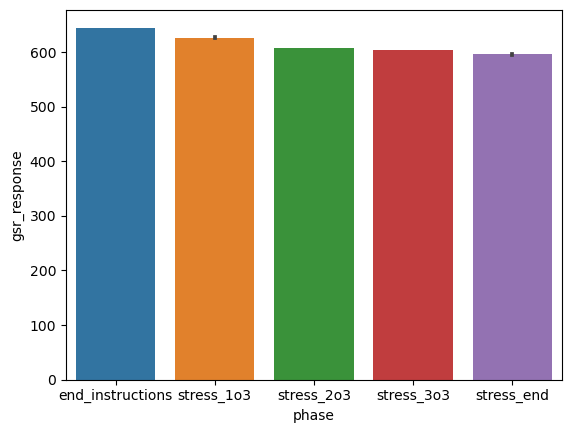

In [57]:
x = 'phase'
y = 'gsr_response'
# hue = 'Condition'

plt.figure()
ax1 = sns.barplot(x=x,y=y, data=df2)

In [58]:
# md = smf.mixedlm("gsr_response ~ (phase*Condition)", data=df[excludePhases], groups=df[excludePhases]["Participant_ID"])
# mdf = md.fit()
# print(mdf.summary())

In [59]:
newDF_GSR = df2

### Example sentence for the GSR results

For the GSR responses we found a main effect of phase across all phases, where the GSR conducatance in the Stress group seemed to be overall higher at each of the phases compared to the Calm condition.    

In [60]:
newDF_GSR

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
3394,481,936,37.140147,end_instructions,100876,1,tahani
3395,510,936,37.152116,end_instructions,100876,1,tahani
3396,494,936,37.162094,end_instructions,100876,1,tahani
3397,510,937,37.172694,end_instructions,100876,1,tahani
3398,546,937,37.183663,end_instructions,100876,1,tahani
...,...,...,...,...,...,...,...
30395,501,505,328.708707,stress_end,99823,1,tahani
30396,486,505,328.719675,stress_end,99823,1,tahani
30397,489,504,328.729647,stress_end,99823,1,tahani
30398,474,505,328.740616,stress_end,99823,1,tahani


In [61]:
# mask = newDF_GSR['Condition'] == 'Stress' 
pd.unique(newDF_GSR['Participant_ID'])

array(['100876', '100', '101092', '101194', '101200', '101248', '101329',
       '101347', '101401', '101443', '101485', '101488', '101521',
       '101584', '101602', '101632', '101688', '101698', '101761',
       '101842', '101857', '101866', '101881', '101893', '102484',
       '102508', '102511', '102640', '102703', '106348', '106366',
       '106918', '10', '110', '112096', '112171', '11', '120', '12', '13',
       '140', '14', '150', '160', '16', '200', '27', '2', '300', '30',
       '350', '3', '400', '40', '450', '500', '50', '5', '60', '6', '70',
       '7', '80', '84598', '85024', '8', '90', '97084', '97102', '97138',
       '97273', '97318', '97354', '97399', '97420', '97471', '97888',
       '99748', '99823'], dtype=object)

### Stress examples

In [62]:
pd.unique(newDF_GSR["Participant_ID"])

array(['100876', '100', '101092', '101194', '101200', '101248', '101329',
       '101347', '101401', '101443', '101485', '101488', '101521',
       '101584', '101602', '101632', '101688', '101698', '101761',
       '101842', '101857', '101866', '101881', '101893', '102484',
       '102508', '102511', '102640', '102703', '106348', '106366',
       '106918', '10', '110', '112096', '112171', '11', '120', '12', '13',
       '140', '14', '150', '160', '16', '200', '27', '2', '300', '30',
       '350', '3', '400', '40', '450', '500', '50', '5', '60', '6', '70',
       '7', '80', '84598', '85024', '8', '90', '97084', '97102', '97138',
       '97273', '97318', '97354', '97399', '97420', '97471', '97888',
       '99748', '99823'], dtype=object)

In [75]:
newDF_GSR

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial
3394,481,936,37.140147,end_instructions,100876,1,tahani
3395,510,936,37.152116,end_instructions,100876,1,tahani
3396,494,936,37.162094,end_instructions,100876,1,tahani
3397,510,937,37.172694,end_instructions,100876,1,tahani
3398,546,937,37.183663,end_instructions,100876,1,tahani
...,...,...,...,...,...,...,...
30395,501,505,328.708707,stress_end,99823,1,tahani
30396,486,505,328.719675,stress_end,99823,1,tahani
30397,489,504,328.729647,stress_end,99823,1,tahani
30398,474,505,328.740616,stress_end,99823,1,tahani


<Axes: xlabel='time', ylabel='gsr_response'>

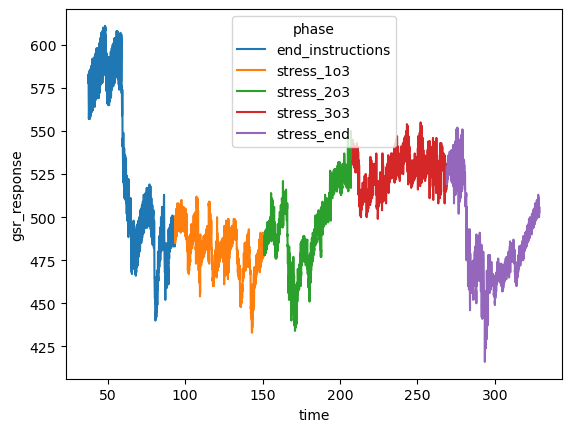

In [77]:
plt.figure()
mask = (newDF_GSR["Participant_ID"] == '99823')  
sns.lineplot(x = 'time', y = 'gsr_response', data=newDF_GSR[mask], hue='phase')
# plt.savefig('Stress example 1.png', dpi=350, bbox_inch=True)

In [85]:
mask = (newDF_GSR["Participant_ID"] == '99823') & (newDF_GSR["phase"] == 'stress_3o3')
averagephase = np.nanmean(newDF_GSR[mask]['gsr_response'])
print("Stress phase 3 out of 3 average gsr: " + str(np.round(averagephase)))

Stress phase 3 out of 3 average gsr: 526.0


In [102]:
newDF_GSR

,heart_rate,gsr_response,time,phase,Participant_ID,Condition,Trial,AverageGSR
3394,481,936,37.140147,end_instructions,100876,1,tahani,935.140979
3395,510,936,37.152116,end_instructions,100876,1,tahani,935.140979
3396,494,936,37.162094,end_instructions,100876,1,tahani,935.140979
3397,510,937,37.172694,end_instructions,100876,1,tahani,935.140979
3398,546,937,37.183663,end_instructions,100876,1,tahani,935.140979
...,...,...,...,...,...,...,...,...
30395,501,505,328.708707,stress_end,99823,1,tahani,485.107529
30396,486,505,328.719675,stress_end,99823,1,tahani,485.107529
30397,489,504,328.729647,stress_end,99823,1,tahani,485.107529
30398,474,505,328.740616,stress_end,99823,1,tahani,485.107529


In [121]:
newDF_GSR_save = newDF_GSR.groupby(['Participant_ID','phase']).apply(lambda x: np.nanmean(x['gsr_response']))

In [122]:
newDF_GSR_save.to_csv('gsr_4_test.csv')

In [91]:
newDF_GSR['AverageGSR'] = newDF_GSR.groupby(['Participant_ID','phase'])['gsr_response'].transform(lambda x: np.nanmean(x))

C:\Users\VR-Lab\AppData\Local\Temp\ipykernel_15976\2017965304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newDF_GSR['AverageGSR'] = newDF_GSR.groupby(['Participant_ID','phase'])['gsr_response'].transform(lambda x: np.nanmean(x))


(400.0, 600.0)

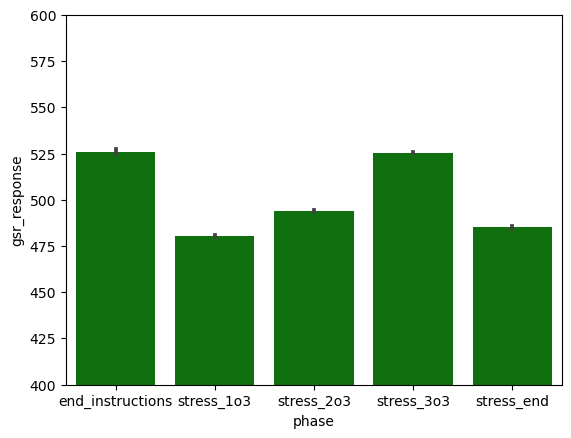

In [101]:
mask = (newDF_GSR["Participant_ID"] == '99823')  
sns.barplot(x = 'phase', y = 'gsr_response', data=newDF_GSR[mask],color='Green')
plt.ylim([400,600])

### Heart rate 

### 3.5 Hear-Rate-Variability (HRV) Computation

In [47]:
pd.unique(df['phase'])

array(['startNow', 'start_experiment', 'buggy_journey',
       'fix_buggy_instructions', 'storm_instructions', 'Baseline',
       'Phase_1', 'Phase_2', 'Phase_3', 'Washout', 'experiment_end'],
      dtype=object)

### Compute the Heart Rate Varibility (HRV) 
Use a window of a certain size (experiment with different window sizes) to compute this value

### RMSSD (Root Mean Square of Successive Differences)

In [48]:
testmask = (df['Participant_ID'] == 'yu191230') & (df['phase'] == 'Phase_1')
rmssdVal = RMSSD_Compute(df[testmask])
print('RMSSD: ' + str(rmssdVal))

RMSSD: 12.976526650164866


In [49]:
df[testmask]['time'].values[-1] - df[testmask]['time'].values[0]

57.58991

In [50]:
numbptx = pd.unique(df['Participant_ID'])
print('Number of participants: ' + str(len(numbptx)))

Number of participants: 41


In [51]:
newDF = None
newDF = df.groupby(['Participant_ID', 'Condition', 'phase']).apply(lambda x: RMSSD_Compute(x)).reset_index().rename(columns={df.index.name:'RMSSD'})

newDF.rename(columns={0: "RMSSD"}, inplace=True)
newDF

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Participant_ID,Condition,phase,RMSSD
0,3,Stress,Baseline,85.856430
1,3,Stress,Phase_1,66.867540
2,3,Stress,Phase_2,58.985470
3,3,Stress,Phase_3,14.633996
4,3,Stress,Washout,3010.246028
...,...,...,...,...
427,yu191230,Stress,buggy_journey,413.000000
428,yu191230,Stress,fix_buggy_instructions,20.346990
429,yu191230,Stress,startNow,24.050542
430,yu191230,Stress,start_experiment,2.280351


In [52]:
excludePhases = (newDF['phase']!='startNow') & (newDF['phase']!='start_experiment') & (newDF['phase']!='buggy_journey') & (newDF['phase']!='fix_buggy_instructions') & (newDF['phase']!='storm_instructions') & (newDF['phase']!='experiment_end') & (newDF['Participant_ID'] != 3)

### RMSSD Normalises: 
Using new approach to compute the phase to baseline differences  

In [54]:

# Step 1: Get the baseline RMSSD for each participant
baseline_rmssd = newDF[excludePhases][newDF[excludePhases]['phase'] == 'Baseline'].set_index('Participant_ID')['RMSSD']

# Step 2: Subtract the baseline RMSSD from each phase's RMSSD for each participant
# Map baseline RMSSD to each row based on Participant_ID, then subtract
newDF['RMSSD_Normed'] = newDF[excludePhases].apply(lambda row: row['RMSSD'] - baseline_rmssd.loc[row['Participant_ID']], axis=1)


In [55]:
newDF[excludePhases]

,Participant_ID,Condition,phase,RMSSD,RMSSD_Normed
10,AC071320,Stress,Baseline,61.916321,0.000000
11,AC071320,Stress,Phase_1,125.932734,64.016414
12,AC071320,Stress,Phase_2,195.062709,133.146388
13,AC071320,Stress,Phase_3,160.551419,98.635098
14,AC071320,Stress,Washout,84.182225,22.265905
...,...,...,...,...,...
422,yu191230,Stress,Baseline,28.893598,0.000000
423,yu191230,Stress,Phase_1,12.976527,-15.917071
424,yu191230,Stress,Phase_2,56.628589,27.734991
425,yu191230,Stress,Phase_3,225.147473,196.253875


<ipython-input-57-7151eb4f9322>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inch" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('RMSSD_Normed.png', dpi=350, bbox_inch=True)


(-50.0, 50.0)

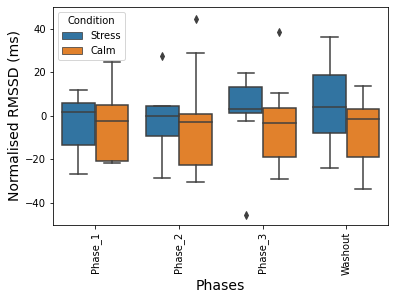

In [57]:
ax1 = sns.boxplot(data=newDF[excludeBase], x='phase', y='RMSSD_Normed',hue='Condition')
ax1.tick_params(axis='x', rotation=90)
plt.xlabel('Phases',fontsize=14)
plt.ylabel('Normalised RMSSD (ms)',fontsize=14)
plt.savefig('RMSSD_Normed.png', dpi=350, bbox_inch=True)
plt.ylim([-50,50])

In [58]:
len(pd.unique(newDF['Participant_ID']))

41

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

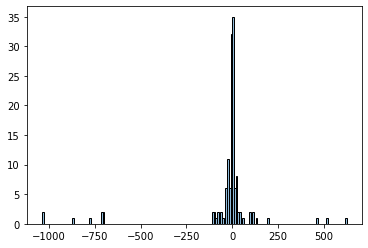

In [59]:
sns.histplot(newDF[excludeBase]['RMSSD_Normed'],kde=True)
pg.normality(newDF[excludeBase]['RMSSD_Normed'])

### Take out outliers from the RMSSD Normalised data

In [60]:
len(pd.unique(newDF_nB['Participant_ID']))

NameError: name 'newDF_nB' is not defined

In [61]:
newDF_nB = newDF[excludeBase]

newDF_nB

,Participant_ID,Condition,phase,RMSSD,RMSSD_Normed
11,AC071320,Stress,Phase_1,125.932734,64.016414
12,AC071320,Stress,Phase_2,195.062709,133.146388
13,AC071320,Stress,Phase_3,160.551419,98.635098
14,AC071320,Stress,Washout,84.182225,22.265905
22,AM051035,Calm,Phase_1,36.725050,20.920691
...,...,...,...,...,...
416,xd,Calm,Washout,10.873803,-2.567855
423,yu191230,Stress,Phase_1,12.976527,-15.917071
424,yu191230,Stress,Phase_2,56.628589,27.734991
425,yu191230,Stress,Phase_3,225.147473,196.253875


In [62]:
newDF_nB2 = newDF_nB[newDF_nB['RMSSD_Normed'] < 50.0]
newDF_nB3 = newDF_nB2[newDF_nB2['RMSSD_Normed'] > -50.0]

newDF_nB3

,Participant_ID,Condition,phase,RMSSD,RMSSD_Normed
14,AC071320,Stress,Washout,84.182225,22.265905
22,AM051035,Calm,Phase_1,36.725050,20.920691
23,AM051035,Calm,Phase_2,60.413437,44.609077
24,AM051035,Calm,Phase_3,19.983968,4.179608
25,AM051035,Calm,Washout,15.878893,0.074533
...,...,...,...,...,...
415,xd,Calm,Phase_3,13.664677,0.223020
416,xd,Calm,Washout,10.873803,-2.567855
423,yu191230,Stress,Phase_1,12.976527,-15.917071
424,yu191230,Stress,Phase_2,56.628589,27.734991


In [63]:
len(pd.unique(newDF_nB3['Participant_ID']))

31

<ipython-input-64-775451c6bd47>:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inch" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('RMSSD_Normed.png', dpi=350, bbox_inch=True)


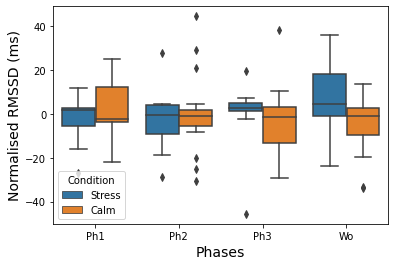

In [64]:
order = ['Phase_1','Phase_2','Phase_3','Washout']
ax1 = sns.boxplot(data=newDF_nB3, x='phase', y='RMSSD_Normed',hue='Condition',order=order)
# ax1.tick_params(axis='x', rotation=90)
plt.xlabel('Phases',fontsize=14)
plt.ylabel('Normalised RMSSD (ms)',fontsize=14)
plt.xticks([0,1,2,3], ['Ph1','Ph2','Ph3','Wo'])

plt.savefig('RMSSD_Normed.png', dpi=350, bbox_inch=True)
# plt.ylim([-50,50])

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

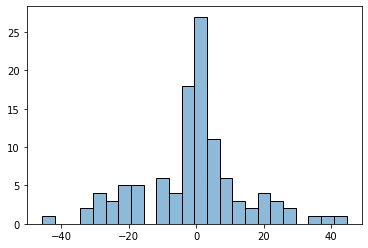

In [65]:
sns.histplot(newDF_nB3['RMSSD_Normed'],kde=True)
pg.normality(newDF_nB3['RMSSD_Normed'])

In [ ]:
print('Calm')

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Calm') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_1')
print('Mean RMSSD phase_1: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Calm') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_2')
print('Mean RMSSD phase_2: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Calm') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_3')
print('Mean RMSSD phase_3: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Calm') &  (newDF_nB3[excludeBase]['phase'] == 'Washout')
print('Mean RMSSD washout: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))



print('\nStress')




mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Stress') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_1')
print('Mean RMSSD phase_1: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Stress') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_2')
print('Mean RMSSD phase_2: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Stress') &  (newDF_nB3[excludeBase]['phase'] == 'Phase_3')
print('Mean RMSSD phase_3: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))

mask = (newDF_nB3['phase']!='Baseline') & (newDF_nB3['phase']!='startNow') & (newDF_nB3['phase']!='start_experiment') & (newDF_nB3['phase']!='buggy_journey') & (newDF_nB3['phase']!='fix_buggy_instructions') & (newDF_nB3['phase']!='storm_instructions') & (newDF_nB3['phase']!='experiment_end') & (newDF_nB3['Participant_ID'] != 3) & (newDF_nB3[excludeBase]['Condition'] == 'Stress') &  (newDF_nB3[excludeBase]['phase'] == 'Washout')
print('Mean RMSSD washout: ' + str(np.round(np.mean(newDF_nB3[mask]['RMSSD_Normed']),3)) + " SD: " + str(np.round(np.std(newDF_nB3[mask]['RMSSD_Normed']),3)))



In [66]:
md = smf.mixedlm("RMSSD_Normed ~ (phase*Condition)", data=newDF_nB3, groups=newDF_nB3["Participant_ID"])
mdf = md.fit()
print(mdf.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        RMSSD_Normed
No. Observations:          109            Method:                    REML        
No. Groups:                31             Scale:                     107.2125    
Min. group size:           1              Log-Likelihood:            -415.7741   
Max. group size:           4              Converged:                 Yes         
Mean group size:           3.5                                                   
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              1.793    4.137  0.433 0.665  -6.315  9.901
phase[T.Phase_2]                      -2.376    3.763 -0.631 0.528  -9.751  4.999
phase[T.Phase_3]                      

<ipython-input-95-8644fe0a683b>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inch" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('RMSSD_Normed.png', dpi=350, bbox_inch=True)


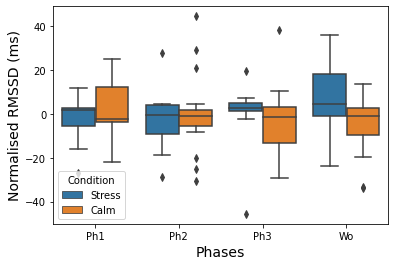

In [95]:
x = 'phase'
y = 'RMSSD_Normed'
hue = 'Condition'
order = ['Phase_1','Phase_2','Phase_3','Washout']

box_pairs = [(('Phase_1','Stress'), ('Phase_1','Calm')),
             (('Phase_2','Stress'), ('Phase_2','Calm')),
             (('Phase_3','Stress'), ('Phase_3','Calm')),
             (('Washout','Stress'), ('Washout','Calm')),]

ax1 = sns.boxplot(data=newDF_nB3, x=x, y=y,hue=hue,order=order)
# ax1.tick_params(axis='x', rotation=90)
plt.xlabel('Phases',fontsize=14)
plt.ylabel('Normalised RMSSD (ms)',fontsize=14)
plt.xticks([0,1,2,3], ['Ph1','Ph2','Ph3','Wo'])



# test_results = add_stat_annotation(ax1, data=newDF_nB3, x=x, y=y, hue=hue, order=order, box_pairs=box_pairs,
#                                    test='t-test_welch', text_format='star',
#                                    loc='outside', verbose=2)

plt.savefig('RMSSD_Normed.png', dpi=350, bbox_inch=True)
# plt.ylim([-50,50])

In [67]:
# # newDF['RMSSD_Normed'] = newDF['Participant_ID']['Baseline'] - newDF['Participant_ID']['Baseline']
# newDFb = None
# newDFb = newDF[excludePhases].groupby(['Participant_ID','Condition', 'phase']).apply(lambda x: RMSSD_Baseline(x)).reset_index()

# newDFb

<ipython-input-68-c917844f94af>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inch" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('RMSSD.png', dpi=350, bbox_inch=True)


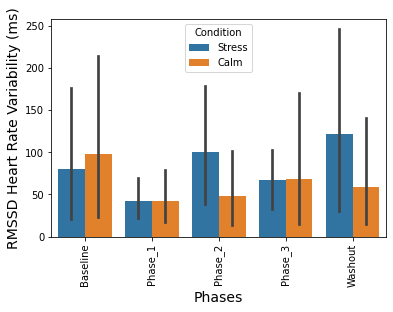

In [68]:
ax1 = sns.barplot(data=newDF[excludePhases], x='phase', y='RMSSD',hue='Condition')
ax1.tick_params(axis='x', rotation=90)
plt.xlabel('Phases',fontsize=14)
plt.ylabel('RMSSD Heart Rate Variability (ms)',fontsize=14)
plt.savefig('RMSSD.png', dpi=350, bbox_inch=True)

In [69]:
ax1 = sns.barplot(data=newDFb, x='phase', y='RMSSD',hue='Condition')
ax1.tick_params(axis='x', rotation=90)

plt.xlabel('Phases',fontsize=14)
plt.ylabel('RMSSD Heart Rate Variability (ms)',fontsize=14)
plt.savefig('RMSSD.png', dpi=350, bbox_inch=True)

NameError: name 'newDFb' is not defined

In [ ]:
# pg.anova(dv=0, between='Condition', effsize="np2", data=newDF).round(3)

pg.mixed_anova(dv=0, between='Condition', within='phase',
               subject='Participant_ID', effsize="ng2", data=newDF[excludePhases]).round(3)

## This is how to report the Linear Mixed Effect model results

In [70]:
print('beta = COEFF_value, SE = se_value, p = p_value')

beta = COEFF_value, SE = se_value, p = p_value


Under methods
Hardware


We used an Valve Index (Valve Corp. WA, USA) 3D immersive VR headset, running at a frame rate of 120 Hz, through an Intel i7 central processing unit Windows 10 PC with a Nvidia GTX-1080Ti graphics processing unit. The virtual environment was created from scratch using the Unreal Engine v5.3.2 (Epic Games, NC, USA) and played through the engine directly to the headset. 

## 4. Export data to SPSS